# Tutorial medida del foco de una lente

# Funcion


In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import imageio
import time
import os
import cv2
import serial
import serial.tools.list_ports
import screeninfo


from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.utils_drawing import draw_several_fields

from py_lab.camera import Camera
from py_lab.motor_linear import Motor
from py_lab.slm import SLM
from py_lab.utils import List_COM_Ports

import matplotlib
import matplotlib.cm as cm
from matplotlib import rcParams




# Camara
ms=1.
seconds=1000*ms

# Motores
s = 1


z0_motor=105

In [36]:
%matplotlib qt
%matplotlib inline

rcParams['image.cmap']='hot'
rcParams['figure.dpi']=125

In [37]:
# Cámara
cam = Camera(name="ImagingSource") 
devices = cam.List_Devices(verbose=True)
cam.Open()
cam.Set_Property("Resolution", "Y800 (1024x768)")
# Framerate
cam.Set_Property("FrameRate", 5)
# Otros parametros
cam.Set_Property("Gain", 0, is_switcher=True)
cam.Set_Property("Gain",1)
#Aquí podemos variar el tiempo de exposición de la cámara. 
value=int(np.log2(1/2000.))
print(value)
cam.Set_Property("Exposure", value)
cam.Start_Live() 

0 : b'DMx 72BUC02 14210296'
-10


1.3371098854208063


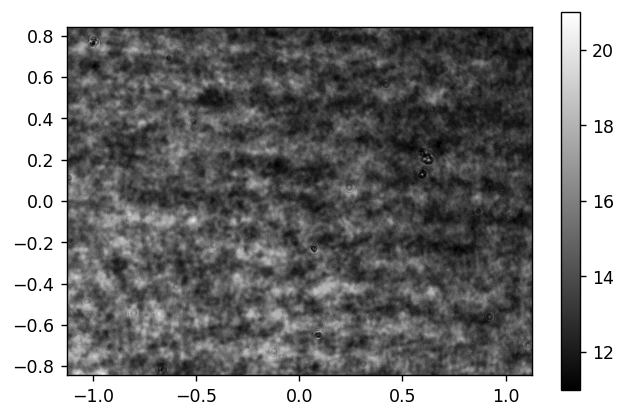

In [38]:
# Comprobamos que se obtiene una imagen. 
image = cam.Get_Image(draw=True)
print(np.std(image))

In [39]:
motor = Motor(name='SMC100')
motor.Open(port='COM3')
motor.Test_Connection()
#El Home es una función inicial para despazar el motor a un punto concreto fijo, el 0 de su sistema. 
motor.Home()
slm = SLM(name="HoloEye2500", M=0.6)

Connecting to SMC100 on COM3
Found stage ILS250PP_PN:B0921669954252_UD:091029
Stage ready


## Creación de la máscara

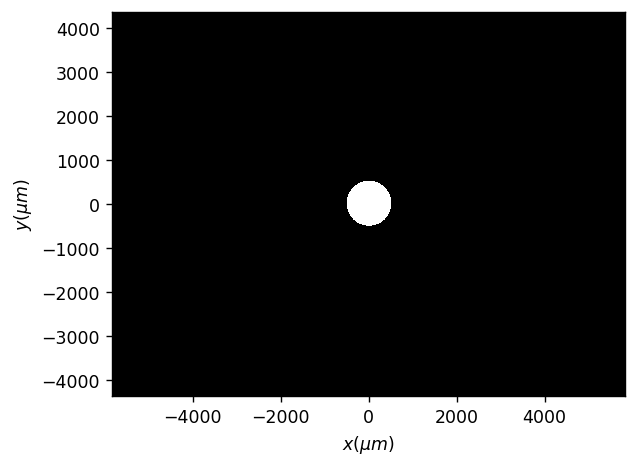

In [40]:
mask = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
mask.circle(r0=(0,0), radius=500, angle=0)
mask.draw(kind='intensity')

slm.Send_Image(mask, norm=1, kind='intensity')

## Preparación de la imagen

In [41]:
motor.Move_Absolute(pos=z0_motor,units='mm', verbose=False, move_time=None)

105.0

In [42]:
cam.Set_Property("Exposure", -9)

## Función

In [43]:
def images_z(slm, mask, positions, z0, filename, get_video=True, delete_images=False):
 
    
    motor.Move_Absolute(pos=z0,units='mm', verbose=False, move_time=None)
    
    time.sleep(1)
    
    mask_null = Scalar_mask_XY(x=mask.x, y=mask.y, wavelength=mask.wavelength)
    mask_null.u=np.zeros_like(mask.u)
        
    for i,z in enumerate(positions): 
        motor.Move_Absolute(pos=z0-z, units='mm', verbose=False, move_time=None)
        
        slm.Send_Image(mask_null, norm=1, kind='intensity')
        time.sleep(0.3)
        imageb = cam.Get_Image()
        slm.Send_Image(mask, norm=1, kind='intensity')
        time.sleep(0.3)
       
        imagem = cam.Get_Image()
        image = imagem - imageb
        image[image<0]=0
        
        if np.sign(z)>=0:
            np.savez('{}_{:.1f}.npz'.format(filename,abs(z)))
            plt.imshow(image, origin='lower');plt.axis('off')
            plt.title('{} z = {:.1f} mm'.format(filename,z))
            plt.savefig('{}_{:.1f}.png'.format(filename,abs(z)))
            
        print('{:.1f}'.format(z),end='\r')
        
    if get_video==True: 
        gif_path = "{}.gif".format(filename)
        with imageio.get_writer(gif_path, mode='I', fps =1) as writer:
            for i,z in enumerate(positions): 
                if np.sign(z)>=0:
                    writer.append_data(imageio.imread('{}_{:.1f}.png'.format(filename,abs(z))))
                    
    if delete_images == True: 
        for i,z in enumerate(positions): 
            if np.sign(z)>=0:
                os.remove('{}_{:.1f}.png'.format(filename,abs(z)))
                os.remove('{}_{:.1f}.npz'.format(filename,abs(z)))
    print('¡Finished!')
    return 

## Development - rendija

¡Finished!


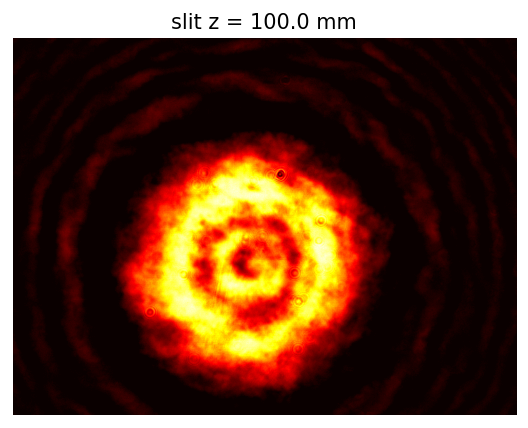

In [27]:
positions= np.linspace(0,100,11) #en mm
images_z(slm, mask, positions, z0_motor, 'slit', get_video=True)

## Function in py_lab

In [44]:
from py_lab.setups import slm_diffractometer
devices=(slm, cam, motor)

¡Finished!


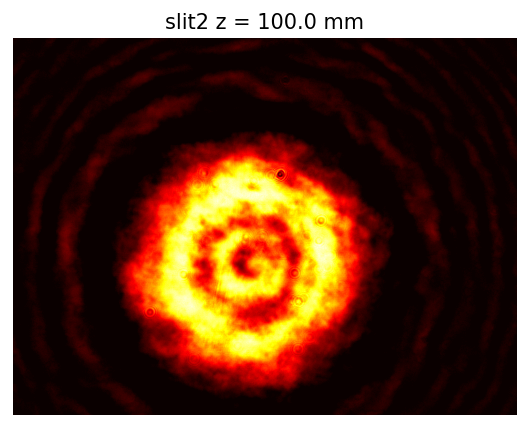

In [50]:
positions= np.linspace(0,100,11) #en mm
names, u_field= slm_diffractometer.images_z(devices, mask, positions, z0=z0_motor, filename='slit2',
                            has_diffractio=True, has_video=True, has_images=False)

In [54]:
u_field.save_data(filename='u_xyz.npz')

'u_xyz.npz'

In [53]:
names

['slit2_0.0.npz',
 'slit2_10.0.npz',
 'slit2_20.0.npz',
 'slit2_30.0.npz',
 'slit2_40.0.npz',
 'slit2_50.0.npz',
 'slit2_60.0.npz',
 'slit2_70.0.npz',
 'slit2_80.0.npz',
 'slit2_90.0.npz',
 'slit2_100.0.npz']

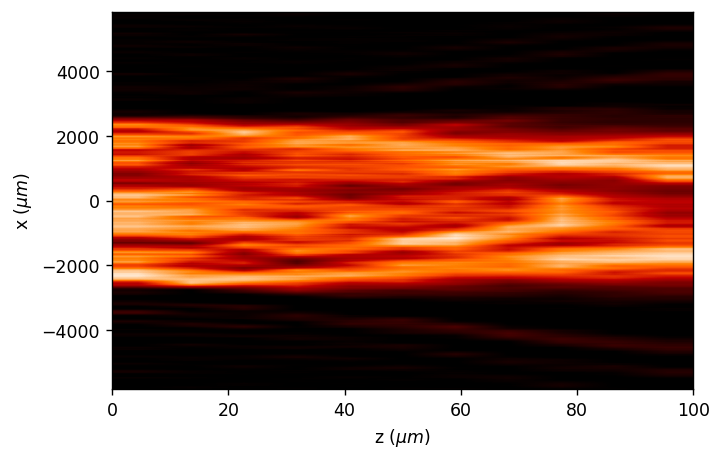

In [52]:
u_field_XZ=u_field.to_Scalar_field_XZ(y0=0)
u_field_XZ.draw()

In [56]:
slm.Close_All_Images()
motor.Close()
cam.Stop_Live()

In [55]:
del u_field, u_field_XZ